<a href="https://colab.research.google.com/github/ramalias/urban-expansion/blob/main/main-urban-expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [9]:
#install library if needed

!pip install rasterio geopandas shapely fiona pyproj
!apt-get install -y gdal-bin
!gdalinfo --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.8.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
GDAL 3.8.4, released 2024/02/08


In [10]:
#import library

import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import glob
import subprocess
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask as rasterio_mask  # Alias the mask function
from rasterio.enums import Resampling
from shapely.geometry import mapping
import json, rasterio

In [12]:
#create main project folder
#run one time only

project_root = '/content/drive/MyDrive/project/urban-exansion'
os.makedirs(project_root, exist_ok=True)

#create folder inside project folder
os.makedirs(os.path.join(project_root, 'data'), exist_ok=True)

print('Workspace created at:', project_root)

Workspace created at: /content/drive/MyDrive/project/urban-exansion


## Folder

In [11]:
#define sentinel folder
SENTINEL_DIR_2019 = "/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2019/tif2019_fix"
Save_dir = os.path.join(SENTINEL_DIR_2019, "subset_grid")
os.makedirs(Save_dir, exist_ok=True)

#define sentinel folder
SENTINEL_DIR_2024 = "/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix"
Save_dir = os.path.join(SENTINEL_DIR_2024, "subset_grid")
os.makedirs(Save_dir, exist_ok=True)


# Unzip the Data (once)

In [13]:
dataset_base_dir = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel'

files = {
    "2019": os.path.join(dataset_base_dir, "S2B_MSIL2A_20190604T020659.zip"),
    "2024": os.path.join(dataset_base_dir, "S2A_MSIL2A_20240612T020701.zip")
}

extracted_dir = os.path.join(dataset_base_dir, 'unzipped')
os.makedirs(extracted_dir, exist_ok=True)

In [14]:
for year, path in files.items():
    year_dir = os.path.join(extracted_dir, year)
    os.makedirs(year_dir, exist_ok=True)
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(year_dir)
    print(f"Extracted {year} data to: {year_dir}")

Extracted 2019 data to: /content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019
Extracted 2024 data to: /content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2024


In [15]:
def find_bands(year_dir):
    band_files = {}

    for band in ['B02', 'B03', 'B04', 'B08', 'B11']:

        if band in ['B11']:
            pattern = f"{year_dir}/**/*{band}_20m.jp2"
        else:
            pattern = f"{year_dir}/**/*{band}_10m.jp2"

        matches = glob.glob(pattern, recursive=True)
        if matches:
            band_files[band] = matches[0]
        else:
            print(f"⚠️ {band} not found in {year_dir}")

    return band_files


bands_2019 = find_bands(os.path.join(extracted_dir, "2019"))
bands_2024 = find_bands(os.path.join(extracted_dir, "2024"))

print("2019 Bands:", bands_2019)
print("2024 Bands:", bands_2024)


2019 Bands: {'B02': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2B_MSIL2A_20190604T020659_N0500_R103_T52SDE_20230808T145552.SAFE/GRANULE/L2A_T52SDE_A011712_20190604T020701/IMG_DATA/R10m/T52SDE_20190604T020659_B02_10m.jp2', 'B03': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2B_MSIL2A_20190604T020659_N0500_R103_T52SDE_20230808T145552.SAFE/GRANULE/L2A_T52SDE_A011712_20190604T020701/IMG_DATA/R10m/T52SDE_20190604T020659_B03_10m.jp2', 'B04': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2B_MSIL2A_20190604T020659_N0500_R103_T52SDE_20230808T145552.SAFE/GRANULE/L2A_T52SDE_A011712_20190604T020701/IMG_DATA/R10m/T52SDE_20190604T020659_B04_10m.jp2', 'B08': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2B_MSIL2A_20190604T020659_N0500_R103_T52SDE_20230808T145552.SAFE/GRANULE/L2A_T52SDE_A011712_20190604T020701/IMG_DATA/R10m/T52SDE_20190

# Convert JP2 to Tiff (once)

In [18]:
# === Sentinel input folders ===
sentinel_2019 = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/S2B_MSIL2A_20190604T020659'
sentinel_2024 = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/S2A_MSIL2A_20240612T020701'

# === Output folders ===
output_base = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel'
output_2019 = os.path.join(output_base, 'tif2019')
output_2024 = os.path.join(output_base, 'tif2024')
os.makedirs(output_2019, exist_ok=True)
os.makedirs(output_2024, exist_ok=True)

# === Bands to extract ===
targets = ["B02", "B03", "B04", "B08", "B11"]

# === Helper function ===
def convert_sentinel_data(input_dir, output_dir, year):
    print(f"Processing {year} data...")
    for b in targets:
        # search recursively inside all subfolders (including IMG_DATA)
        pattern = os.path.join(input_dir, "**", f"*{b}*.jp2")
        src_files = sorted(glob.glob(pattern, recursive=True))

        if not src_files:
            print(f"No file found for band {b} in {year}")
            continue

        for src in src_files:
            # Keep relative path to prevent filename conflicts
            rel_path = os.path.relpath(src, input_dir).replace("/", "_")
            dst_name = rel_path.replace(".jp2", ".tif")
            dst = os.path.join(output_dir, dst_name)

            cmd = [
                "gdal_translate", "-of", "COG",
                "-co", "COMPRESS=LZW", "-co", "NUM_THREADS=ALL_CPUS",
                src, dst
            ]
            print(f"Converting [{year}] → {os.path.basename(src)}")
            subprocess.run(cmd, check=True)

    print(f"Finished converting {year}. Files saved in: {output_dir}")

# === Run conversion for both years ===
convert_sentinel_data(sentinel_2019, output_2019, 2019)
convert_sentinel_data(sentinel_2024, output_2024, 2024)

print("All conversions complete!")

Processing 2019 data...
Converting [2019] → T52SDE_20190604T020659_B02_10m.jp2
Converting [2019] → T52SDE_20190604T020659_B02_20m.jp2
Converting [2019] → T52SDE_20190604T020659_B02_60m.jp2
Converting [2019] → T52SDE_20190604T020659_B03_10m.jp2
Converting [2019] → T52SDE_20190604T020659_B03_20m.jp2
Converting [2019] → T52SDE_20190604T020659_B03_60m.jp2
Converting [2019] → T52SDE_20190604T020659_B04_10m.jp2
Converting [2019] → T52SDE_20190604T020659_B04_20m.jp2
Converting [2019] → T52SDE_20190604T020659_B04_60m.jp2
Converting [2019] → T52SDE_20190604T020659_B08_10m.jp2
Converting [2019] → T52SDE_20190604T020659_B11_20m.jp2
Converting [2019] → T52SDE_20190604T020659_B11_60m.jp2
Finished converting 2019. Files saved in: /content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2019
Processing 2024 data...
Converting [2024] → T52SDE_20240612T020701_B02_10m.jp2
Converting [2024] → T52SDE_20240612T020701_B02_20m.jp2
Converting [2024] → T52SDE_20240612T020701_B02_60m.jp2
Conver

#Check the resolution

## 2019

In [20]:
def find_first(pattern):
    files = glob.glob(os.path.join(SENTINEL_DIR_2019, pattern))
    return files[0] if files else None

bands = {
    "B02": find_first("*B02*.tif"),
    "B03": find_first("*B03*.tif"),
    "B04": find_first("*B04*.tif"),
    "B08": find_first("*B08*.tif"),
    "B11": find_first("*B11*.tif")
}

#Vegetative band (B08) ---> this is for reference (to check resolution, coordinate system and bound)
ref = rasterio.open(bands["B08"])
bounds = ref.bounds
print("=== Sentinel Raster info ===")
print("Original resolution:", (ref.height, ref.width))
print("CRS:", ref.crs)
print("Bounds", bounds)
print("Number of Bands:", ref.count)
print("Data Type:", ref.dtypes)
print("Transform (affine):", ref.transform)

=== Sentinel Raster info ===
Original resolution: (10980, 10980)
CRS: EPSG:32652
Bounds BoundingBox(left=399960.0, bottom=3890220.0, right=509760.0, top=4000020.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 399960.00|
| 0.00,-10.00, 4000020.00|
| 0.00, 0.00, 1.00|


## Preview 2019

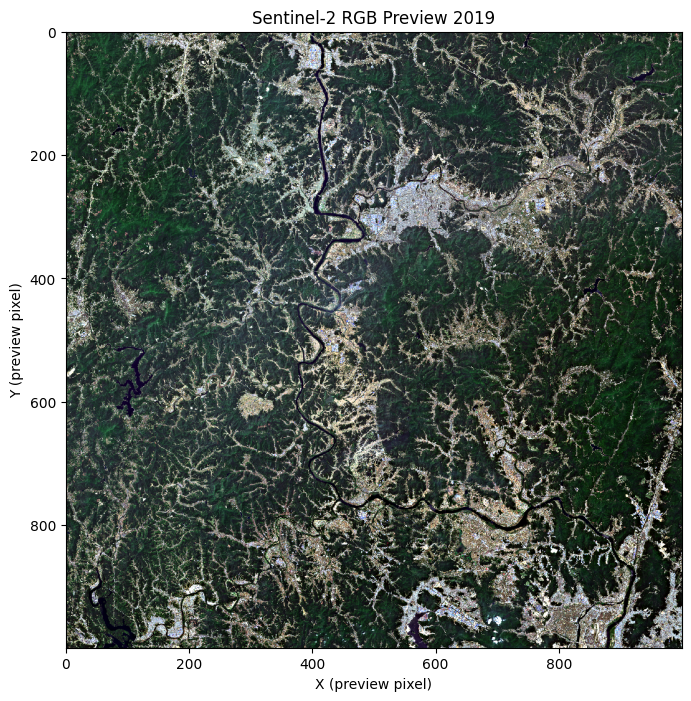

In [21]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(bands["B04"]) as r: R2019 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands["B03"]) as r: G2019 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands["B02"]) as r: B2019 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands["B08"]) as r: NIR2019 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands["B11"]) as r: SWIR2019 = r.read(1, out_shape=(scale, scale))

#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

#Merge into RGB image
rgb = np.dstack([qstretch(R2019), qstretch(G2019), qstretch(B2019)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

plt.title("Sentinel-2 RGB Preview 2019")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("/content/drive/MyDrive/project/urban-exansion/output/2019/Sentinel2_preview_2019",
            dpi=300, bbox_inches='tight')
plt.show()

## 2024

In [22]:
def find_first(pattern):
    files = glob.glob(os.path.join(SENTINEL_DIR_2024, pattern))
    return files[0] if files else None

bands = {
    "B02": find_first("*B02*.tif"),
    "B03": find_first("*B03*.tif"),
    "B04": find_first("*B04*.tif"),
    "B08": find_first("*B08*.tif"),
    "B11": find_first("*B11*.tif")
}

#Vegetative band (B08) ---> this is for reference (to check resolution, coordinate system and bound)
ref = rasterio.open(bands["B08"])
bounds = ref.bounds
print("=== Sentinel Raster info ===")
print("Original resolution:", (ref.height, ref.width))
print("CRS:", ref.crs)
print("Bounds", bounds)
print("Number of Bands:", ref.count)
print("Data Type:", ref.dtypes)
print("Transform (affine):", ref.transform)

=== Sentinel Raster info ===
Original resolution: (10980, 10980)
CRS: EPSG:32652
Bounds BoundingBox(left=399960.0, bottom=3890220.0, right=509760.0, top=4000020.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 399960.00|
| 0.00,-10.00, 4000020.00|
| 0.00, 0.00, 1.00|


## Preview 2024

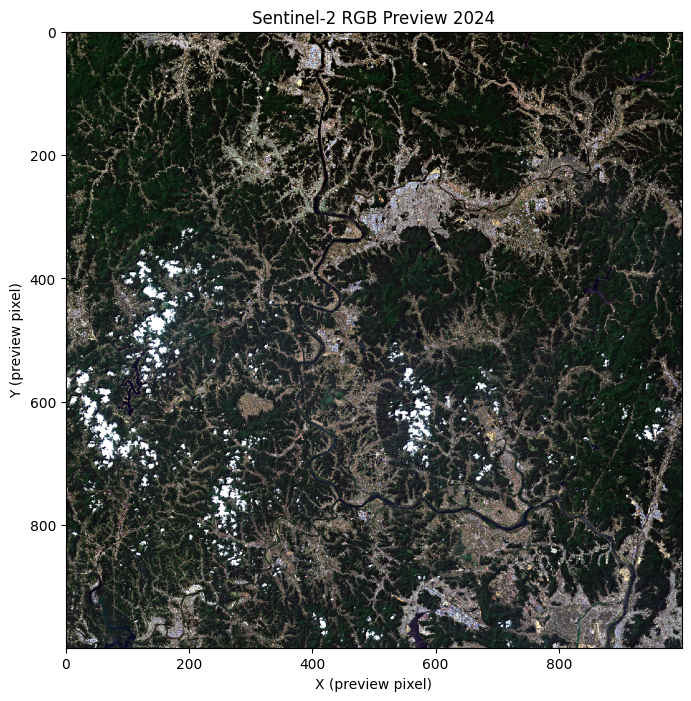

In [23]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(bands["B04"]) as r: R2024 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands["B03"]) as r: G2024 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands["B02"]) as r: B2024 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands["B08"]) as r: NIR2024 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands["B11"]) as r: SWIR2024 = r.read(1, out_shape=(scale, scale))


#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

#Merge into RGB image
rgb = np.dstack([qstretch(R2024), qstretch(G2024), qstretch(B2024)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

plt.title("Sentinel-2 RGB Preview 2024")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("/content/drive/MyDrive/project/urban-exansion/output/2024/Sentinel2_preview_2024",
            dpi=300, bbox_inches='tight')
plt.show()

## Administrative Boundaries

In [24]:
gadm_path = '/content/drive/MyDrive/project/urban-exansion/data/02_Data_boundary/boundary daegu/daegu_boundary.shp'
gdf = gpd.read_file(gadm_path)
print("=== GADM Boundary Info ===")
print("CRS:", gdf.crs)
print("Number of Polygons:", len(gdf))
print(gdf.head())

=== GADM Boundary Info ===
CRS: EPSG:4326
Number of Polygons: 1
     GID_1 GID_0      COUNTRY NAME_1                         VARNAME_1  \
0  KOR.4_1   KOR  South Korea  Daegu  Taegu|Daegu Gwang'yeogsi|Taegu-g   

       NL_NAME_1       TYPE_1          ENGTYPE_1 CC_1 HASC_1  ISO_1  \
0  대구광역시 | 大邱廣域市  Gwangyeoksi  Metropolitan City   NA  KR.TG  KR-27   

                                            geometry  
0  POLYGON ((128.45745 35.63956, 128.45743 35.639...  


# Reprojection



sentinel raster info : EPSG:32652
GADM CRS before :  EPSG:4326
GADM CRS after :  PROJCS["WGS 84 / UTM zone 52N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32652"]]


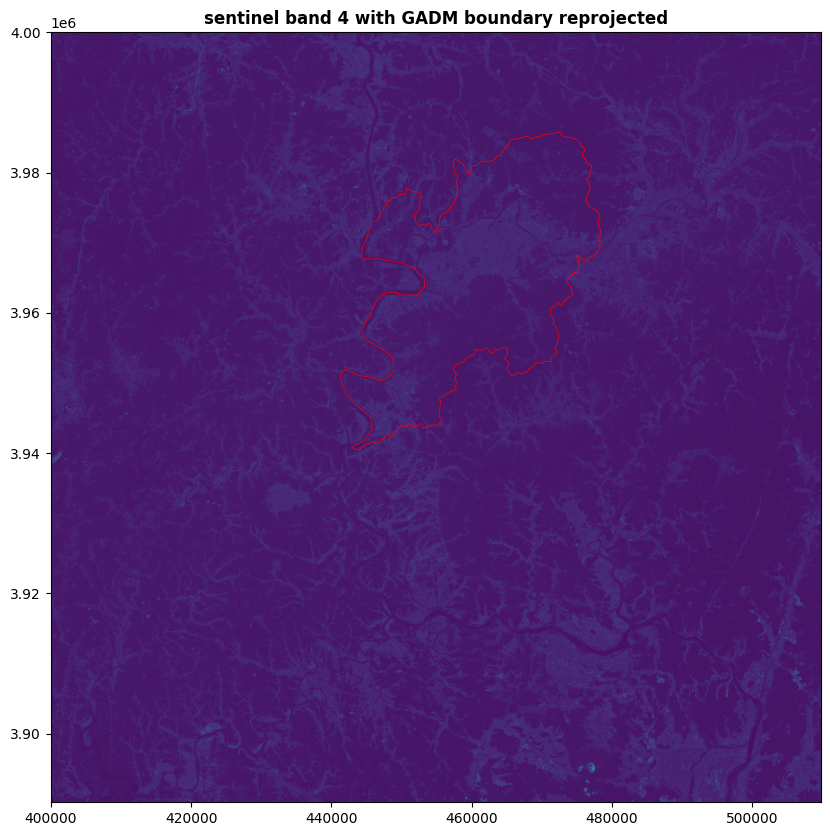

In [25]:
#file path
raster_path = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2019/tif2019_fix/R10m_T52SDE_20190604T020659_B04_10m.tif'

#open raster
raster = rasterio.open(raster_path)
print('sentinel raster info :', raster.crs)
#GADM city boundary
print('GADM CRS before : ', gdf.crs)

#Reproject GADM to match the sentinel CRS
gadm_reproject = gdf.to_crs(raster.crs)
print('GADM CRS after : ', gadm_reproject.crs)

#save the reproject
gadm_reproject.to_file('/content/drive/MyDrive/project/urban-exansion/data/02_Data_boundary/daegu_boundary_reproject.shp')

#plot
fig, ax = plt.subplots(figsize=(10,10))
show(raster, ax=ax, title='sentinel band 4 with GADM boundary reprojected')
gadm_reproject.boundary.plot(ax=ax, color='red', linewidth=0.5)
plt.show()

# Clip

In [26]:
#reprojected daegu boundary
daegu_boundary = '/content/drive/MyDrive/project/urban-exansion/data/02_Data_boundary/daegu_boundary_reproject.shp'

## 2019

In [35]:
#path
clipped_output_dir = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019'
os.makedirs(clipped_output_dir, exist_ok=True)

# Load the reprojected Daegu boundary and get its geometries
d_boundary = gpd.read_file(daegu_boundary)
geom = [mapping(d_boundary.geometry.squeeze())]

#list sentinel tiff
band_files = [f for f in os.listdir(SENTINEL_DIR_2019) if f.endswith('.tif')]
print('found bands:', band_files)

#loop through each band
for band in band_files:
  in_path = os.path.join(SENTINEL_DIR_2019, band)
  out_path = os.path.join(clipped_output_dir, band.replace('.tif', '_clipped.tif'))

  with rasterio.open(in_path) as src:
    out_image, out_transform = rasterio_mask(src,geom, crop=True) # Use aliased function
    out_meta = src.meta.copy()
    out_meta.update({
        'height': out_image.shape[1],
        'width': out_image.shape[2], # Corrected from 'weight' to 'width'
        'transform': out_transform
    })

    with rasterio.open(out_path, 'w', **out_meta) as dest:
      dest.write(out_image)
    print(f'clipped {band} -> saved to {out_path}')

found bands: ['R10m_T52SDE_20190604T020659_B02_10m.tif', 'R10m_T52SDE_20190604T020659_B03_10m.tif', 'R10m_T52SDE_20190604T020659_B04_10m.tif', 'R10m_T52SDE_20190604T020659_B08_10m.tif', 'R20m_T52SDE_20190604T020659_B11_20m.tif']
clipped R10m_T52SDE_20190604T020659_B02_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R10m_T52SDE_20190604T020659_B02_10m_clipped.tif
clipped R10m_T52SDE_20190604T020659_B03_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R10m_T52SDE_20190604T020659_B03_10m_clipped.tif
clipped R10m_T52SDE_20190604T020659_B04_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R10m_T52SDE_20190604T020659_B04_10m_clipped.tif
clipped R10m_T52SDE_20190604T020659_B08_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R10m_T52SDE_20190604T020659_B08_10m_clipped.tif
clipped R20m_T52SDE_20190604T020659_B11_20m.tif -> 

## 2024

In [36]:
#path
clipped_output_dir = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024'
os.makedirs(clipped_output_dir, exist_ok=True)

# Load the reprojected Daegu boundary and get its geometries
d_boundary = gpd.read_file(daegu_boundary)
geom = [mapping(d_boundary.geometry.squeeze())]

#list sentinel tiff
band_files = [f for f in os.listdir(SENTINEL_DIR_2024) if f.endswith('.tif')]
print('found bands:', band_files)

#loop through each band
for band in band_files:
  in_path = os.path.join(SENTINEL_DIR_2024, band)
  out_path = os.path.join(clipped_output_dir, band.replace('.tif', '_clipped.tif'))

  with rasterio.open(in_path) as src:
    out_image, out_transform = rasterio_mask(src,geom, crop=True, filled=True)
    out_meta = src.meta.copy()
    out_meta.update({
        'height': out_image.shape[1],
        'width': out_image.shape[2], # Corrected from 'weight' to 'width'
        'transform': out_transform
    })

    with rasterio.open(out_path, 'w', **out_meta) as dest:
      dest.write(out_image)
    print(f'clipped {band} -> saved to {out_path}')

found bands: ['R10m_T52SDE_20240612T020701_B02_10m.tif', 'R10m_T52SDE_20240612T020701_B03_10m.tif', 'R10m_T52SDE_20240612T020701_B04_10m.tif', 'R10m_T52SDE_20240612T020701_B08_10m.tif', 'R20m_T52SDE_20240612T020701_B11_20m.tif']
clipped R10m_T52SDE_20240612T020701_B02_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024/R10m_T52SDE_20240612T020701_B02_10m_clipped.tif
clipped R10m_T52SDE_20240612T020701_B03_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024/R10m_T52SDE_20240612T020701_B03_10m_clipped.tif
clipped R10m_T52SDE_20240612T020701_B04_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024/R10m_T52SDE_20240612T020701_B04_10m_clipped.tif
clipped R10m_T52SDE_20240612T020701_B08_10m.tif -> saved to /content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024/R10m_T52SDE_20240612T020701_B08_10m_clipped.tif
clipped R20m_T52SDE_20240612T020701_B11_20m.tif -> 

## Check clipped data

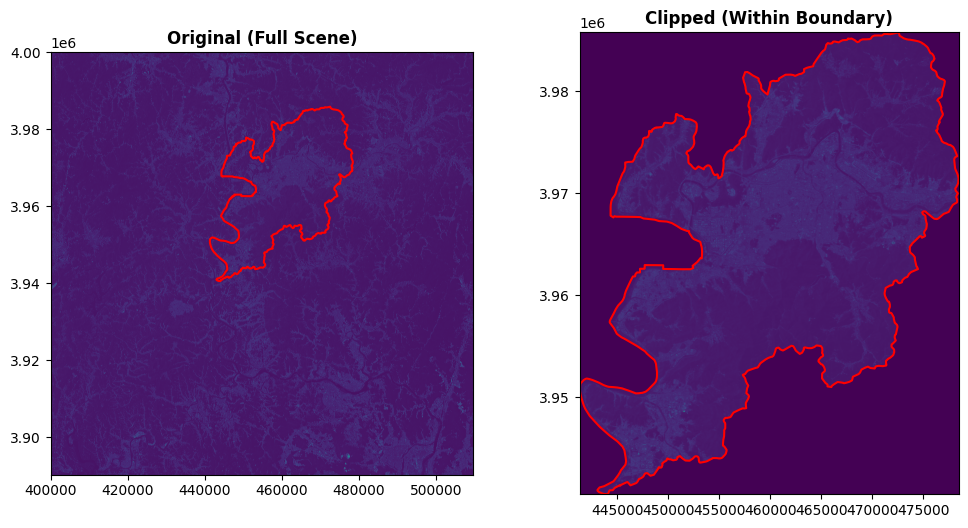

In [29]:
#path
clipped_path = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R10m_T52SDE_20190604T020659_B04_10m_clipped.tif'
original_path = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2019/tif2019_fix/R10m_T52SDE_20190604T020659_B04_10m.tif'
boundary_path = '/content/drive/MyDrive/project/urban-exansion/data/02_Data_boundary/daegu_boundary_reproject.shp'

#load
orig = rasterio.open(original_path)
clipped = rasterio.open(clipped_path)
boundary = gpd.read_file(boundary_path)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
show(orig, ax=ax1, title="Original (Full Scene)")
d_boundary.boundary.plot(ax=ax1, color='red')
show(clipped, ax=ax2, title="Clipped (Within Boundary)")
d_boundary.boundary.plot(ax=ax2, color='red')
plt.show()

In [32]:
print("Original bounds:", orig.bounds)
print("Clipped bounds :", clipped.bounds)
print("Original shape (rows, cols):", (orig.height, orig.width))
print("Clipped shape (rows, cols):", (clipped.height, clipped.width))

Original bounds: BoundingBox(left=399960.0, bottom=3890220.0, right=509760.0, top=4000020.0)
Clipped bounds : BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
Original shape (rows, cols): (10980, 10980)
Clipped shape (rows, cols): (4531, 3714)


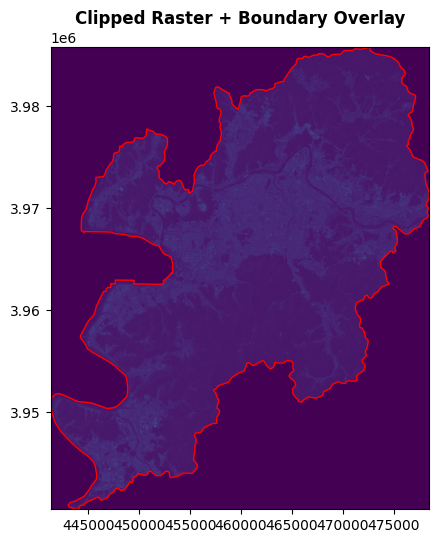

In [30]:
fig, ax = plt.subplots(figsize=(6,6))
show(clipped, ax=ax, title="Clipped Raster + Boundary Overlay")
d_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=1)
plt.show()


In [31]:
print("Raster CRS:", clipped.crs)
print("Boundary CRS:", d_boundary.crs)

Raster CRS: EPSG:32652
Boundary CRS: EPSG:32652


# resampling B11 (20 to 10)

## 2019

In [34]:
from rasterio.enums import Resampling

# Reference 10m band (use Red: B04)
ref_path = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R10m_T52SDE_20190604T020659_B04_10m_clipped.tif'

# Band to resample (example: B11)
band_to_resample = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2019/R20m_T52SDE_20190604T020659_B11_20m_clipped.tif'
output_resampled = "/content/drive/MyDrive/project/urban-exansion/data/04_Resampled_data/B11_resampled_10m.tif"

os.makedirs("/content/drive/MyDrive/project/urban-exansion/data/04_Resampled_data/", exist_ok=True)

# Read reference
with rasterio.open(ref_path) as ref:
    ref_transform = ref.transform
    ref_width = ref.width
    ref_height = ref.height
    ref_crs = ref.crs

# Resample 20m → 10m
with rasterio.open(band_to_resample) as src:
    data = src.read(
        out_shape=(src.count, ref_height, ref_width),
        resampling=Resampling.bilinear
    )
    new_meta = src.meta.copy()
    new_meta.update({
        "height": ref_height,
        "width": ref_width,
        "transform": ref_transform,
        "crs": ref_crs
    })
    with rasterio.open(output_resampled, "w", **new_meta) as dst:
        dst.write(data)

print(f"Resampled {os.path.basename(band_to_resample)} to 10m")


Resampled R20m_T52SDE_20190604T020659_B11_20m_clipped.tif to 10m


In [37]:
# Band to resample (example: B11)
band_to_resample = '/content/drive/MyDrive/project/urban-exansion/data/03_Clipped_data/2024/R20m_T52SDE_20240612T020701_B11_20m_clipped.tif'
output_resampled = '/content/drive/MyDrive/project/urban-exansion/data/04_Resampled_data/B11_resampled_10m.tif'

# Read reference
with rasterio.open(ref_path) as ref:
    ref_transform = ref.transform
    ref_width = ref.width
    ref_height = ref.height
    ref_crs = ref.crs

# Resample 20m → 10m
with rasterio.open(band_to_resample) as src:
    data = src.read(
        out_shape=(src.count, ref_height, ref_width),
        resampling=Resampling.bilinear
    )
    new_meta = src.meta.copy()
    new_meta.update({
        "height": ref_height,
        "width": ref_width,
        "transform": ref_transform,
        "crs": ref_crs
    })
    with rasterio.open(output_resampled, "w", **new_meta) as dst:
        dst.write(data)

print(f"Resampled {os.path.basename(band_to_resample)} to 10m")

Resampled R20m_T52SDE_20240612T020701_B11_20m_clipped.tif to 10m
